# Federated Variational Autoencoders in biomedical data
Here, an example of a variability analysis using a Multi-channel variational autoencoder proposed by [Antelmi _et_ al](http://proceedings.mlr.press/v97/antelmi19a.html).

In [1]:
import copy
import pandas as pd

import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
N_CENTERS = 4
N_ROUNDS = 10   # Number of iterations between all the centers training and the aggregation process.

N_EPOCHS = 15   # Number of epochs before aggregating
BATCH_SIZE = 48
LR = 1e-3       # Learning rate

We define a set of functions to distribute our dataset across multiple centers (`split_iid`) and for doing federated averaging (`federated_averaging`).

In [3]:
import numpy as np
def split_iid(df, n_centers):
    """ Split pandas DataFrame dataset randomly into n_centers """
    data = df.sample(frac=1)  # Shuffle dataset
    data =  np.array_split(data, n_centers)
    return data

In [4]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

## Federating dataset

In [5]:
csv = 'https://gitlab.inria.fr/ssilvari/flhd/-/raw/master/heterogeneous_data/pseudo_adni.csv?inline=false'
df = pd.read_csv(csv)
df.sample()

,SEX,AGE,PTEDUCAT,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl,APOE4,ABETA.MEDIAN.bl,PTAU.MEDIAN.bl,TAU.MEDIAN.bl
785,0.950093,73.599446,15.548222,2.670125,11.304515,26.868209,32.532705,-0.058803,7.606843,9.6364,0.731003,0.020091,0.003822,0.014123,0.001893,0.539067,188.57027,56.527068,106.89067


Now, `federated_dataset` is a list of subsets of the main dataset.

In [6]:
federated_dataset = split_iid(df, n_centers=N_CENTERS)
print('Number of centers:', len(federated_dataset))

Number of centers: 4


Finally, we must parse each dataframe in the form of a tensor Dataset grouping variables in 5 channels:
* Volumetric data
* Demographics
* Cognition
* Genetics: Apolipoprotein E (APOE)
* Fluid biomarkers: Amyloid beta (Abeta) and Tau concentrations in the Cerebrospinal fluid (CSF).

In [7]:
def get_data_as_multichannel_tensor_dataset(df):
    """Takes a dataframe, splits it into multiple channels and parse each channel as a tensor"""
    channel_1 = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
    channel_2 = ['SEX', 'AGE', 'PTEDUCAT']
    channel_3 = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']
    channel_4 = ['APOE4']
    channel_5 = ['ABETA.MEDIAN.bl', 'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl']

    def as_tensor(cols):
        return torch.tensor(df[cols].values).float()
    
    return [as_tensor(channel_1), as_tensor(channel_2), as_tensor(channel_3), as_tensor(channel_4), as_tensor(channel_5)]

## Defining and distributing a model: Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [8]:
!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

In [9]:
from mcvae.models import Mcvae, ThreeLayersVAE, VAE

First, it is necessary to define a model.

In [43]:
dummy_data = [torch.zeros_like(x) for x in get_data_as_multichannel_tensor_dataset(df.sample())]  # Dummy data to initialize the input layer size
lat_dim = 3  # Size of the latent space for this autoencoder
vae_class = VAE  # Architecture of the autoencoder (VAE: Single layer)

In [44]:
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()

Now replicate a copy of the models across different centers.

In [45]:
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

Train in a federated fashion

In [46]:
init_params = model.state_dict()
for round_i in range(N_ROUNDS):
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X = get_data_as_multichannel_tensor_dataset(client_dataset)

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

====> Epoch:    0/15 (0%)	Loss: 439.9036	LL: -439.0095	KL: 0.8941	LL/KL: -491.0039
====> Epoch:   10/15 (67%)	Loss: 530.3003	LL: -529.4180	KL: 0.8823	LL/KL: -600.0606
====> Epoch:    0/15 (0%)	Loss: 690.5297	LL: -689.6356	KL: 0.8941	LL/KL: -771.3131
====> Epoch:   10/15 (67%)	Loss: 228.5592	LL: -227.6834	KL: 0.8758	LL/KL: -259.9705
====> Epoch:    0/15 (0%)	Loss: 663.4890	LL: -662.5949	KL: 0.8941	LL/KL: -741.0698
====> Epoch:   10/15 (67%)	Loss: 277.6280	LL: -276.7472	KL: 0.8808	LL/KL: -314.2077
====> Epoch:    0/15 (0%)	Loss: 268.3115	LL: -267.4174	KL: 0.8941	LL/KL: -299.0891
====> Epoch:   10/15 (67%)	Loss: 412.7573	LL: -411.8764	KL: 0.8809	LL/KL: -467.5475
====> Epoch:   20/30 (67%)	Loss: 275.9202	LL: -275.0525	KL: 0.8677	LL/KL: -316.9901
====> Epoch:   20/30 (67%)	Loss: 347.4671	LL: -346.6003	KL: 0.8668	LL/KL: -399.8580
====> Epoch:   20/30 (67%)	Loss: 197.9353	LL: -197.0673	KL: 0.8680	LL/KL: -227.0315
====> Epoch:   20/30 (67%)	Loss: 464.5324	LL: -463.6664	KL: 0.8660	LL/KL: -535.4

## Results visualization
Using the final parameters we can evaluate the performance of the model by visualizing the testing set onto the latent space.

In [47]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Here we store in a list the deconding weights estimated for each modality. 
**We are interested in the decoding weights corresponding to each dimmension of the latent space $Z_i$**.

In [86]:
decoding_weights_dict = {k: w.detach().numpy() for k, w in trained_model.state_dict().items() if 'W_out.weight' in k}

In [103]:
lat_dim_names = [f'$Z_{{{i}}}$' for i in range(lat_dim)]
weights = pd.DataFrame()

for channel_i, weights_i in enumerate(decoding_weights_dict.values(), 1):
    channel_df = pd.DataFrame(weights_i, columns=lat_dim_names)
    channel_df['channel'] = channel_i

    weights = weights.append(channel_df, ignore_index=True)

weights.index = df.columns
weights.index.name = 'biomarker'
weights.reset_index(inplace=True)
weights.head()

,biomarker,$Z_{0}$,$Z_{1}$,$Z_{2}$,channel
0,SEX,-0.142914,0.019806,-0.412941,1
1,AGE,-0.277777,0.446932,0.204469,1
2,PTEDUCAT,0.023073,0.364177,-0.036446,1
3,CDRSB.bl,0.385323,-0.092444,-0.129499,1
4,ADAS11.bl,-0.116536,-0.083172,-0.086657,1


We prepare the dataset in a form so it is easily visualizable.

In [106]:
weights_melt = weights.melt(id_vars=['biomarker', 'channel'], var_name='latent_var')
weights_melt.sample()

,biomarker,channel,latent_var,value
52,Entorhinal.bl,3,$Z_{2}$,0.459813


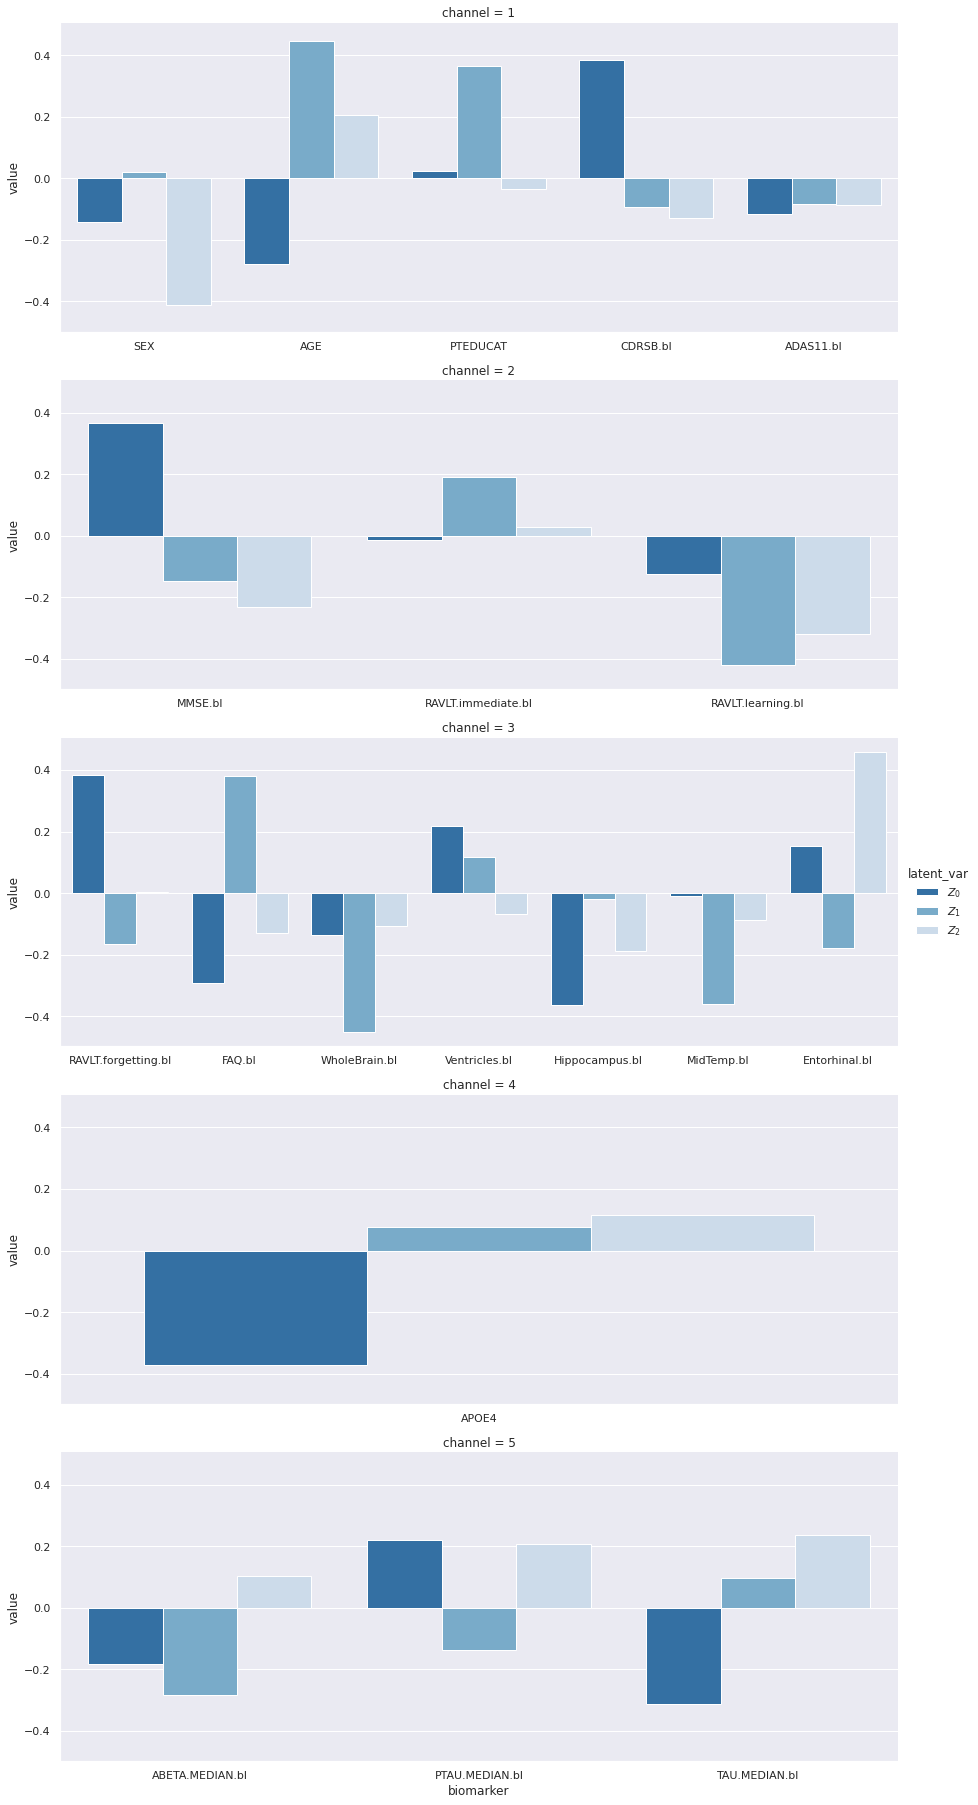

In [117]:
sns.catplot(data=weights_melt, x='biomarker', y='value', hue='latent_var', kind='bar', col='channel', col_wrap=1, aspect=2.5, sharex=False, palette='Blues_r')
plt.show()